In [312]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import mne

import glob
import os
import sys
from scipy.io import savemat, loadmat
from scipy.stats import pearsonr, spearmanr, sem
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats
from pingouin import rm_anova

sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import*
mne.set_log_level('CRITICAL')

### TO DO: 

make this notebook handle the pre and post data at once without manually setting the period each time
also different musician levels

### Set up 

In [313]:
#-----------------------------
#           LOADING FILES AND INITIALIZING DIRECTORIES
#-----------------------------

#use MIDI folders or audio folders to change triggers
#epochs_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz'
epochs_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz_corrected'

#epochs_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05'


#figs_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/figures'


#channels and times for plotting
ch_names_64, ch_names_72 = load_channels()
erp_times = create_erp_times(-0.5,0.5, 128)

good_listen_subjects, good_motor_subjects, good_error_subjects, musicians, nonmusicians = load_subject_lists_LME()
subjects_to_process =  good_error_subjects
#subjects_to_process = ['14', '15']
#subjects_to_process = musicians
#subjects_to_process.remove('02')

#some promising differences when including just musicians (subjects 5,6,7)


In [314]:
def load_error_epochs_bysubject(epochs_dir, subjects_to_process, epoch_type, sub_ave = True):
    """ 
    Loads the epochs for error trials
    subjects_to_process: list of subjects where each element is a string. e.g. ['01', '02']
    epoch_type: which error keystrokes are included. Currently 'all', 'inv', 'shinv' and 'norm'
        ---future: separate keystrokes that are the first keystroke after a map change from all the other keystrokes
    ---
    Returns a dataframe with columns 'subject', 'period', 'musician', and 'epoch_type'.
        each row of ['epochs'] is an array of shape n_channels x n_timepoints, and is the average of all epochs from one subject
    
    """

    epochs_df = pd.DataFrame(columns = ['subject', 'period', 'musician', 'epochtype', 'epochs'])
    good_listen_subjects, good_motor_subjects, musicians, nonmusicians = load_subject_lists()

    assert isinstance (subjects_to_process, list)

    for subject in subjects_to_process:
        print('Processing subject: ', subject)

        if subject in musicians: 
            musician = 1
        else: 
            musician = 0
        for period in ['pre', 'post']:
            file_epochs_pre = glob.glob(os.path.join(epochs_dir, f'error_epochs_{epoch_type}_{period}_{subject}.fif'))[0]
            epochs_sub = mne.read_epochs(file_epochs_pre)

            if sub_ave:
                epochs_sub = np.mean(epochs_sub.get_data()[:, :64, :], axis = 0) #get only the eeg channels and average all trials per subject
            else: 
                #epochs_sub = epochs_sub.get_data()[:, :64, :]
                epochs_sub = epochs_sub.get_data()

            df_sub = pd.DataFrame({
                'subject': subject,
                'period' : period,
                'musician' : musician,
                'epochtype': epoch_type,
                'epochs': [epochs_sub]
            })
            epochs_df = pd.concat([epochs_df, df_sub])


    epochs_df.reset_index(drop=True, inplace=True)
    return (epochs_df)


In [315]:
epochs_df_all = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'all')
epochs_df_inv = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'inv')
epochs_df_shinv = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'shinv')
epochs_df_norm = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'norm')

epochs_df_firsts = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'firsts', sub_ave=False)
epochs_df_others = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'others', sub_ave=False)


Processing subject:  01
Processing subject:  04
Processing subject:  05
Processing subject:  06


Processing subject:  07
Processing subject:  08
Processing subject:  09
Processing subject:  10
Processing subject:  11
Processing subject:  12
Processing subject:  13
Processing subject:  14
Processing subject:  15
Processing subject:  16
Processing subject:  17
Processing subject:  18
Processing subject:  19
Processing subject:  20
Processing subject:  01
Processing subject:  04
Processing subject:  05
Processing subject:  06
Processing subject:  07
Processing subject:  08
Processing subject:  09
Processing subject:  10
Processing subject:  11
Processing subject:  12
Processing subject:  13
Processing subject:  14
Processing subject:  15
Processing subject:  16
Processing subject:  17
Processing subject:  18
Processing subject:  19
Processing subject:  20
Processing subject:  01
Processing subject:  04
Processing subject:  05
Processing subject:  06
Processing subject:  07
Processing subject:  08
Processing subject:  09
Processing subject:  10
Processing subject:  11
Processing subje

In [316]:
epochs_df_firsts['evokeds'] = epochs_df_firsts['epochs'].apply(lambda x: np.mean(x, axis=0))
epochs_df_others['evokeds'] = epochs_df_others['epochs'].apply(lambda x: np.mean(x, axis=0))

In [317]:
def find_ev_diffs(df):
    """ 
    Takes prepared epochs dataframes from pre and post (or any other to compare )
    """
    df['evokeds'] = df['epochs'].apply(lambda x: np.mean(x, axis=0))

    df_diff = df.pivot(['period'])

    return df_diff


In [318]:
df_diff = epochs_df_firsts[['subject', 'period']].copy()
df_diff['diff'] = epochs_df_firsts['evokeds'] - epochs_df_others['evokeds']

In [319]:
def diff_score_df(data_df, scores_df, sub_col_name, data_columns): 

    """ 
    combines the df with training scores and the df with some participant-specific data to allow corr analyses

    Note: subject is the unformatted column. sub is formatted as strings with leading 0s, e.g. '02'
    power_diff_df: expected columns: sub, diff
    scores_df: exported from training repo with scores from all subjects. Expected columns:  subject, score, musician, rank
    sub_col_name: name of subject column in data df (usually sub or subject)
    data_columns: columns from the data
    ---
    returns diff_df_ranked: df with sub, training score, data of interest, and relative ranking to other subjects
    """

    #configure sub column of scores_df to make it match the column in the diff df
    scores_df['sub'] = scores_df['subject'].astype(int).apply(lambda x: f'{x:02d}')

    #configure data df
    data_df['sub'] = data_df[sub_col_name]
    assert data_df['sub'].apply(lambda x: isinstance(x, str) and len(x) == 2).all(), "Subjects should be expressed as a string with 2 characters"

    data_filt_df = data_df[['sub'] + data_columns]
    data_filt_df.reset_index(drop=True)

    diff_df_ranked = data_filt_df.merge(scores_df, on =['sub'])
    #power_diff_df_ranked = power_diff_df_ranked[['sub', 'diff', 'musician', 'score', 'rank']]

    return diff_df_ranked



In [320]:

scores_df = pd.read_csv('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/utils/training_scores_rank.csv')
corr_df = diff_score_df(df_diff, scores_df, 'subject', ['diff', 'period'])


#### Stats test on subset epochs

In [359]:
def subset_epochs(epochs_df, n_epochs, ave = False):
    if ave:
        epochs_sub = np.mean([epoch[np.random.choice(epoch.shape[0], n_epochs, replace=True), :, :]
                                        for epoch in epochs_df['epochs']], axis = 1)
    else:
        epochs_sub =[epoch[np.random.choice(epoch.shape[0], n_epochs, replace=True), :, :]
                                        for epoch in epochs_df['epochs']]

    epochs_df_new = epochs_df.copy()

    epochs_df_new['epochs'] = [epochs_sub[i] for i in range(epochs_df.shape[0])]

    return epochs_df_new

def ci95(arr, axis):
    lower_bound = np.percentile(arr, 2.5, axis = axis)
    upper_bound = np.percentile(arr, 97.5, axis = axis)

    return lower_bound, upper_bound

In [421]:
n_iter = 200
n_samp = 100

diffs_fo_boot = []

for i in range(n_iter):

    epochs_df_firsts_sub = subset_epochs(epochs_df_firsts, n_samp)
    epochs_df_others_sub = subset_epochs(epochs_df_others, n_samp)
    epochs_df_firsts_sub['evokeds'] =  epochs_df_firsts_sub['epochs'].apply(lambda x: np.mean(x, axis=0)) 
    epochs_df_others_sub['evokeds'] = epochs_df_others_sub['epochs'].apply(lambda x: np.mean(x, axis = 0))

    df_diff_sub = epochs_df_firsts_sub[['subject', 'period']].copy()
    df_diff_sub['diff'] = epochs_df_firsts_sub['evokeds'] - epochs_df_others_sub['evokeds']

    time_idx = time_index_custom([0.1], erp_times)
    period = 'pre'
    diffs_fo_sub = np.stack(df_diff_sub.query(f"period =='{period}'")['diff'].values)[:, :64, time_idx].squeeze()

    diffs_fo_boot.append(diffs_fo_sub)

diffs_fo_boot = np.stack(diffs_fo_boot)
#_, p_fo = t_over_channels(diffs_fo_sub)
diffs_fo_boot_mean = np.mean(diffs_fo_boot, axis = 1)

In [447]:
ci_l, ci_u = ci95(diffs_fo_boot_mean, axis = 0)
print(ci_l[47], ci_u[47])

-1.3992821483629097e-06 -3.807362219547434e-07


Text(0.5, 1.0, 'Distr of differences between firsts and others, POz, 100 samples, 200 bootstrap iterations')

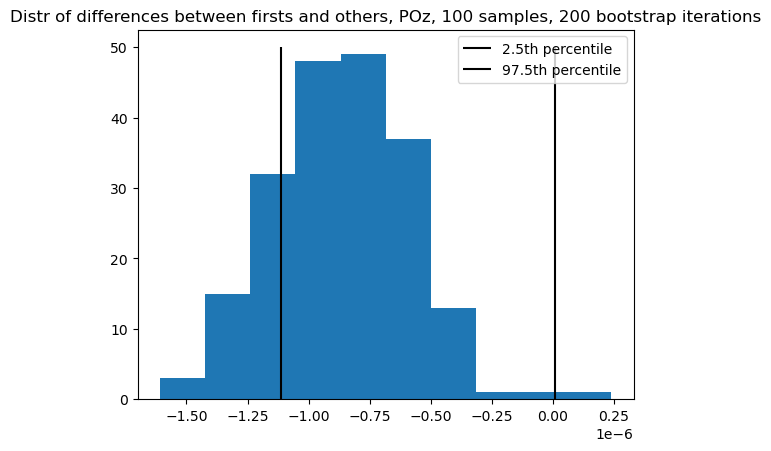

In [449]:
#plot bootstrap distribution
ch_to_plot = 'POz'
ch_idx = ch_index([ch_to_plot])
plt.hist(diffs_fo_boot_mean[:, 47])
plt.vlines(ci_l[ch_idx], 0, 50, color = 'black', label = '2.5th percentile')
plt.vlines(ci_u[ch_idx], 0, 50, color = 'black', label = '97.5th percentile')
plt.legend()

plt.title(f'Distr of differences between firsts and others, {ch_to_plot}, {n_samp} samples, {n_iter} bootstrap iterations')

## Plot channel differences

In [323]:
# ch_to_plot = 'FCz'
# ch_idx = ch_index([ch_to_plot])[0]
# period = 'post'


# plt.figure(figsize=(10,8))
# for sub in subjects_to_process:
#     plt.plot(erp_times, corr_df.query(f"sub == '{sub}' and period == '{period}' ")['diff'].values[0][ch_idx], label=sub, linewidth=0.5)

# #mean
# #diff_values = np.array([row[ch_idx] for row in df_diff['diff']])
# diff_values = np.array([row[ch_idx] for row in corr_df.query(f"period == '{period}'")['diff']])

# #diff_values = np.array([row[ch_idx] for row in corr_df.query(f"sub == '{sub}' and period == '{period}' ")['diff']])

# mean_diff = np.mean(diff_values, axis=0)
# sem_diff = np.std(diff_values, axis=0) / np.sqrt(diff_values.shape[0])

# plt.plot(erp_times, mean_diff, label='Mean', linewidth=1.5, color='red')

# #SEM
# sem_diff = np.std(diff_values, axis=0) / np.sqrt(diff_values.shape[0])
# plt.fill_between(
#     erp_times, 
#     mean_diff - sem_diff, 
#     mean_diff + sem_diff, 
#     color='red', 
#     alpha=0.17, 
#     label='SEM'
# )

# plt.plot()
# plt.legend()
# plt.title(f'First note after map change vs other notes, {period} training, {ch_to_plot}')
# #plt.vlines(time_to_plot, 0,4e-6, color = 'black')
# plt.hlines(0,-0.5,0.5, color = 'black')

PearsonRResult(statistic=0.4770945277229415, pvalue=0.04528079206424872)


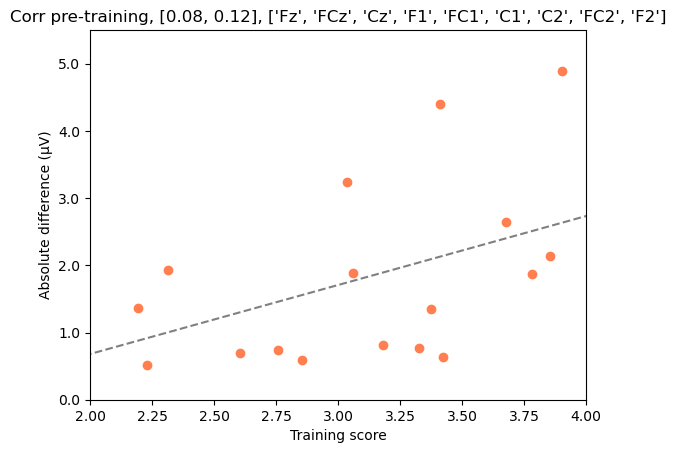

In [324]:
time_to_plot = [0.08, 0.12]
ch_to_plot = ['Fz', 'FCz', 'Cz', 'F1', 'FC1', 'C1', 'C2', 'FC2', 'F2']
#ch_to_plot = ['Fz']
ch_idx = ch_index(ch_to_plot)
period = 'pre'

#correlation between differences and training performance
time_idx = time_index_custom(time_to_plot, erp_times)
#corr_df['diff_tocorr'] = corr_df['diff'].apply(lambda x: np.mean(x[ch_idx, time_idx]))
corr_df['diff_tocorr'] = corr_df['diff'].apply(lambda x: np.max(np.abs(x[ch_idx, time_idx[0]:time_idx[1]].mean(axis = 0))))
corr_df_per = corr_df.query(f'period == "{period}"')

#plot points
plt.scatter(corr_df_per['score'], corr_df_per['diff_tocorr'], color = 'coral')


#pearson corr
print(pearsonr(corr_df_per['score'], corr_df_per['diff_tocorr']))

# Generate the regression line
slope, intercept, r_value, p_value_corr, std_err = stats.linregress(corr_df_per['score'], corr_df_per['diff_tocorr'])
x = np.linspace(0, 4, 100)
y = slope * x + intercept
plt.plot(x, y, label=f'R={r_value:.2f}, p = {p_value_corr:.2f}', linestyle = '--', color = 'grey')


plt.xlabel('Training score')
plt.ylabel(f'Absolute difference (µV)')
plt.xlim(2,4)
plt.ylim(0,5.5e-6)
plt.title(f'Corr {period}-training, {time_to_plot}, {ch_to_plot}')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV


#plt.title(f'First - other keystrokes, {period}-training, {time_to_plot*1000} ms, {ch_to_plot}')
#plt.hlines(0,0,4, color = 'black')
#plt.legend()

### Comparison over channels
(no bootstrapping here)

In [325]:
#utils for t-tests 

def invert_p_values(p_values_arr):
    """ 
    Transforms an arr of p values to prepare for plotting using mne.viz.plot_topomap
    Inverts the p values (replace x with 1-x) so that smaller p values 
    Makes all insignificant p values 0 so that when inverted, it shows up as white in the topomap

    p_values_arr: a 1d array of p-values
    returns: p_values_inv


    """
    p_values_inv = [1-x if x <0.05 else 0 for x in p_values_arr]
    return p_values_inv

def t_over_channels(array):
    """
    takes a difference array of size n_subs, n_ch (64 expected) and tests whether the differences are sigificantly different from 0

    ---
    returns:
    t: test statistic of size 64, one for each channel
    p: test statistic of size 64
    """
    t_values = []
    p_values = []
    
    for ch in range(64):
        diff_to_test = array[:, ch]
        t, p = wilcoxon_1samp(diff_to_test)
        t_values.append(t)
        p_values.append(p)

    p_values = fdrcorrection(p_values)[1]
    
    return t_values, p_values


def p_mask(diffs, p_values):

    """ 
    masks differences between two conditions so that only significant differences are plotted on the topomap
    diffs: 1d array
    p_values: 1d array of same size
    """
    assert diffs.shape == p_values.shape, 'diffs and p-values should be the same shape'
    diffs_masked = diffs.copy()
    diffs_masked[p_values>0.05] = 0
    return diffs_masked

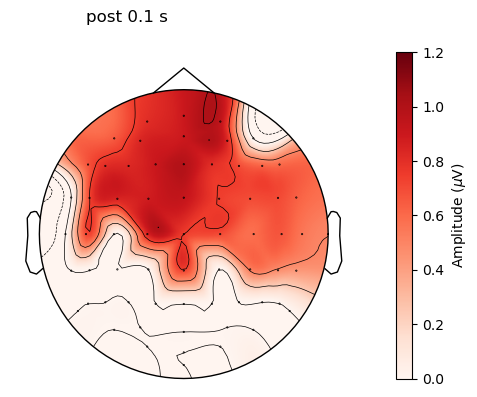

In [326]:
#stats over channels

period = 'post'
time_to_plot = 0.1


time_idx = time_index_custom([time_to_plot], erp_times)[0]
diffs_fo= np.stack(corr_df.query(f'period == "{period}"')['diff'].values)[:, :64, time_idx]
_, p_fo = t_over_channels(diffs_fo)

#calculate differences
diffs_fo_t = diffs_fo.mean(axis = 0)
diffs_fo_t = p_mask(diffs_fo_t, p_fo)
diffs_fo_t_abs = np.abs(diffs_fo_t)

info = load_ep_info()

fig, axes = plt.subplots(figsize=(8,4))
im1, _ = mne.viz.plot_topomap(diffs_fo_t_abs, info, axes = axes, show=False, vlim=(0, 1.2e-6))

# im1, _ = mne.viz.plot_topomap(diffs_fo_t, info, axes = axes, show=False)


cbar = plt.colorbar(im1, ax=axes, orientation='vertical')
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert scale from V to µV
cbar.set_label(r'Amplitude ($\mu$V)')

fig.suptitle(f'{period} {time_to_plot} s')
plt.tight_layout()

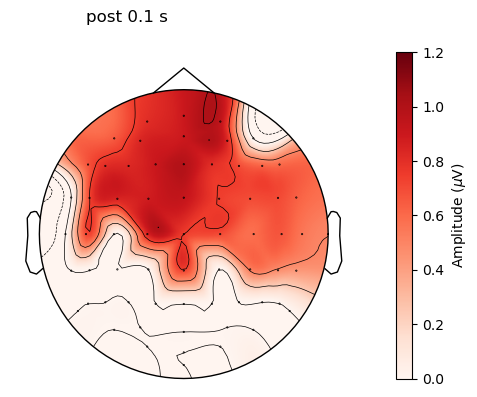

In [327]:
#stats over channels with bootstrapping
 
period = 'post'
time_to_plot = 0.1


time_idx = time_index_custom([time_to_plot], erp_times)[0]
diffs_fo= np.stack(corr_df.query(f'period == "{period}"')['diff'].values)[:, :64, time_idx]
_, p_fo = t_over_channels(diffs_fo)

#calculate differences
diffs_fo_t = diffs_fo.mean(axis = 0)
diffs_fo_t = p_mask(diffs_fo_t, p_fo)
diffs_fo_t_abs = np.abs(diffs_fo_t)

info = load_ep_info()

fig, axes = plt.subplots(figsize=(8,4))
im1, _ = mne.viz.plot_topomap(diffs_fo_t_abs, info, axes = axes, show=False, vlim=(0, 1.2e-6))

# im1, _ = mne.viz.plot_topomap(diffs_fo_t, info, axes = axes, show=False)


cbar = plt.colorbar(im1, ax=axes, orientation='vertical')
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert scale from V to µV
cbar.set_label(r'Amplitude ($\mu$V)')

fig.suptitle(f'{period} {time_to_plot} s')
plt.tight_layout()

### Compare first and other ERPs directly

In [328]:
# #comparing firsts and others in all periods
# mean_firsts = epochs_df_firsts['evokeds'].mean(axis=0)[ch_idx].flatten()
# sem_firsts = sem(epochs_df_firsts['evokeds'],axis=0)[ch_idx].flatten()

# mean_others = epochs_df_others['evokeds'].mean(axis=0)[ch_idx][0].flatten()
# sem_others = sem(epochs_df_others['evokeds'],axis=0)[ch_idx].flatten()

# plt.figure(figsize=(10, 6))
# col = 'darkslateblue'

# # Plot the first dataset
# plt.plot(erp_times, mean_firsts, label='firsts', color=col)
# plt.fill_between(erp_times, mean_firsts - sem_firsts, mean_firsts + sem_firsts, color = col, alpha=0.6)

# # Plot the other dataset
# plt.plot(erp_times, mean_others, label='others', color=col, alpha = 0.6)
# plt.fill_between(erp_times, mean_others - sem_others, mean_others + sem_others, color=col, alpha=0.3)

# # Add labels, legend, and grid
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude (µV)')
# plt.title(f'ERP first and others, all participants, pre and post')
# plt.hlines(0, -0.5, 0.5, color = 'black', linewidth = 0.7)
# plt.vlines(0, np.min(mean_firsts), np.max(mean_firsts), color = 'black', linestyles= '--')
# plt.legend()
# plt.show()


In [329]:
epochs_df_firsts_per.iloc[0]['evokeds'].shape

(72, 129)

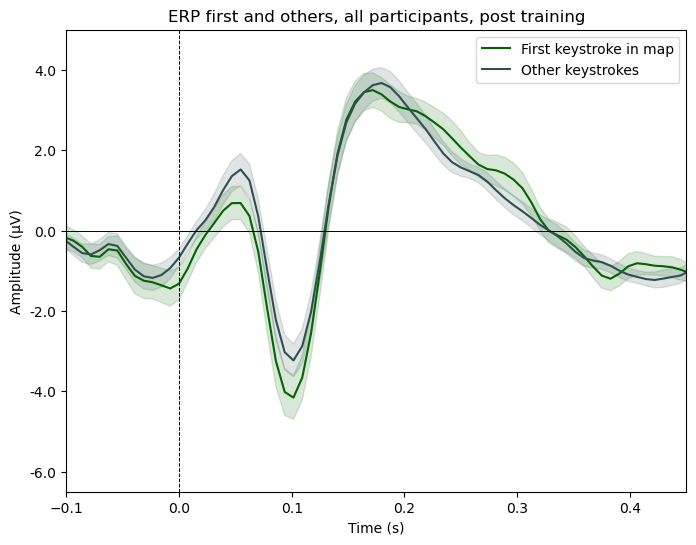

In [330]:
#comparing firsts and others in only one period
ch_idx = ch_index(['FCz'])

period = 'post'

epochs_df_firsts_per = epochs_df_firsts.query(f'period == "{period}"')
epochs_df_others_per = epochs_df_others.query(f'period == "{period}"')

mean_firsts = epochs_df_firsts_per['evokeds'].mean(axis=0)[ch_idx].flatten()
sem_firsts = sem(epochs_df_firsts_per['evokeds'],axis=0)[ch_idx].flatten()

# # Calculate the mean and SEM for the other dataset
mean_others = epochs_df_others_per['evokeds'].mean(axis=0)[ch_idx].flatten()
sem_others = sem(epochs_df_others_per['evokeds'],axis=0)[ch_idx].flatten()

plt.figure(figsize=(8, 6))


# Plot the first dataset
plt.plot(erp_times, mean_firsts, label='First keystroke in map', color='darkgreen')
plt.fill_between(erp_times, mean_firsts - sem_firsts, mean_firsts + sem_firsts, color = 'darkgreen', alpha=0.15)

# Plot the other dataset
plt.plot(erp_times, mean_others, label='Other keystrokes', color='darkslategrey')
plt.fill_between(erp_times, mean_others - sem_others, mean_others + sem_others, color='darkslategrey', alpha=0.15)

# Add labels, legend, and grid
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title(f'ERP first and others, all participants, {period} training')
plt.hlines(0, -0.5, 0.5, color = 'black', linewidth = 0.7)
plt.vlines(0, -6.5e-6, 5e-6, color = 'black', linestyles= '--', linewidth = 0.7)

plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV

plt.xlim(-0.1, 0.45)
plt.ylim(-6.5e-6, 5e-6)
plt.legend()
plt.show()


In [331]:
np.array([row[ch_idx] for row in corr_df.query(f"period == 'pre'")['diff']]).mean(axis = 1).shape

(18, 129)

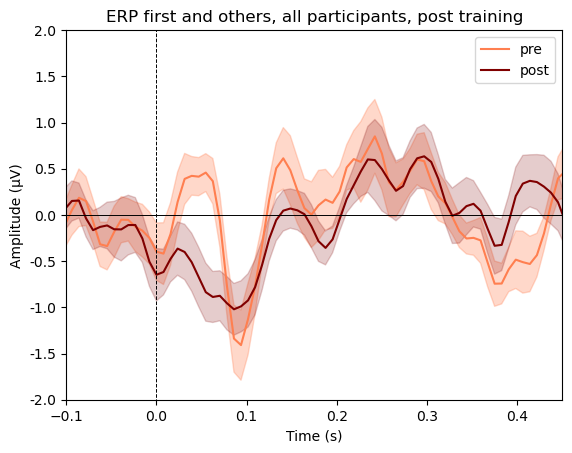

In [332]:
#compare difference between first and others in each epoch

col = 'orangered'

#find average diff value
corr_df_pre = corr_df.query(f"period == 'pre'")['diff']
corr_df_post = corr_df.query(f"period == 'post'")['diff']
diff_values_pre = np.array([row[ch_idx] for row in corr_df_pre]).mean(axis = 0).mean(axis=0) 
diff_sem_pre = sem(np.array([row[ch_idx] for row in corr_df_pre]).mean(axis = 1))
diff_values_post =  np.array([row[ch_idx] for row in corr_df_post]).mean(axis = 0).mean(axis=0) 
diff_sem_post = sem(np.array([row[ch_idx] for row in corr_df_post]).mean(axis = 1))


plt.plot(erp_times, diff_values_pre, color = 'coral', label = 'pre')
plt.fill_between(erp_times, diff_values_pre-diff_sem_pre, diff_values_pre+diff_sem_pre, color = 'coral', alpha = 0.3)
plt.plot(erp_times, diff_values_post, color = 'maroon',label = 'post')
plt.fill_between(erp_times, diff_values_post-diff_sem_post, diff_values_post+diff_sem_post, color = 'maroon', alpha = 0.2)

# Add labels, legend, and grid
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title(f'ERP first and others, all participants, {period} training')
plt.hlines(0, -0.5, 0.5, color = 'black', linewidth = 0.7)
plt.vlines(0, -6.5e-6, 5e-6, color = 'black', linestyles= '--', linewidth = 0.7)

plt.legend()

plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV
plt.xlim(-0.1, 0.45)
plt.ylim(-2e-6, 2e-6)

plt.show()


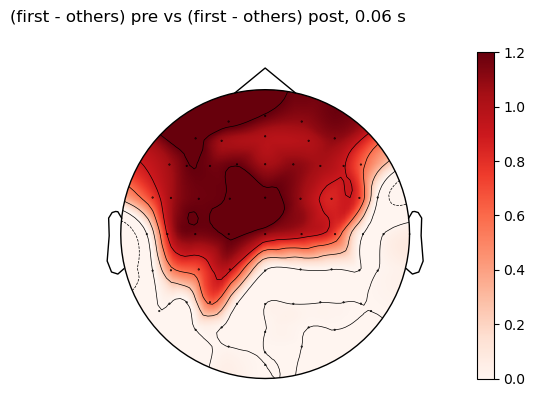

In [333]:
#stats over channels

time_to_plot = 0.06

time_idx = time_index_custom([time_to_plot], erp_times)[0]

diff_pre = np.stack(corr_df.query(f"period == 'pre'")['diff'])[:, :64, time_idx]
diff_post = np.stack(corr_df.query(f"period == 'post'")['diff'])[:, :64, time_idx]
diff_diff = diff_post-diff_pre


_, p_pp = t_over_channels(diff_diff)

#calculate differences
diffs_pp_t = diff_diff.mean(axis = 0)
diffs_pp_t = p_mask(diffs_pp_t, p_pp)
diffs_pp_t_abs = np.abs(diffs_pp_t)

info = load_ep_info()

fig, axes = plt.subplots(figsize=(8,4))
im1, _ = mne.viz.plot_topomap(diffs_pp_t_abs, info, axes = axes, show=False, vlim =( 0, 1.2e-6))

cbar = plt.colorbar(im1, ax=axes, orientation='vertical')
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert scale from V to µV

fig.suptitle(f'(first - others) pre vs (first - others) post, {time_to_plot} s')
plt.tight_layout()

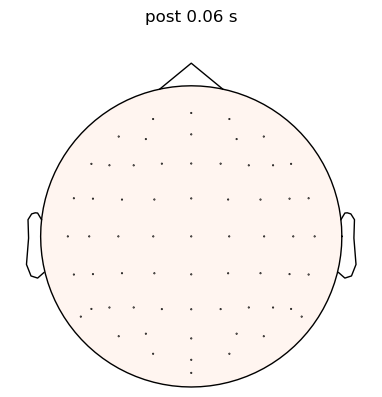

In [334]:
t_values = []
p_values = []
diffs = []


for ch in range(64):
    diff_to_test = [x[ch, time_idx] for x in corr_df_per['diff'].values]
    t, p = wilcoxon_1samp(diff_to_test)
    t_values.append(t)
    p_values.append(p)
    diffs.append(np.mean(diff_to_test))

p_values = fdrcorrection(p_values)[1]
p_values_inv = invert_p_values(p_values)


diffs_toplot = diffs.copy()
diffs_toplot = np.array(diffs_toplot)
# insig_idx = np.where(p_values<0.05)[0]
diffs_toplot[p_values>0.05] = 0


info = load_ep_info()

fig, axes = plt.subplots(figsize=(8,4))
im1, _ = mne.viz.plot_topomap(diffs_toplot, info, axes = axes, show=False)


fig.suptitle(f'{period} {time_to_plot} s')
plt.tight_layout()

In [335]:
# period = 'pre'

# epochs_df_firsts_per = epochs_df_firsts.query(f'period == "{period}"')
# epochs_df_others_per = epochs_df_others.query(f'period == "{period}"')

# mean_firsts = epochs_df_firsts_per['evokeds'].mean(axis=0)[ch_idx]
# sem_firsts = sem(epochs_df_firsts_per['evokeds'],axis=0)[ch_idx]

# # # Calculate the mean and SEM for the other dataset
# mean_others = epochs_df_others_per['evokeds'].mean(axis=0)[ch_idx]
# sem_others = sem(epochs_df_others_per['evokeds'],axis=0)[ch_idx]

# plt.figure(figsize=(10, 6))
# col = 'darkslateblue'

# # Plot the first dataset
# plt.plot(erp_times, mean_firsts, label='firsts', color=col)
# plt.fill_between(erp_times, mean_firsts - sem_firsts, mean_firsts + sem_firsts, color = col, alpha=0.6)

# # Plot the other dataset
# plt.plot(erp_times, mean_others, label='others', color=col, alpha = 0.6)
# plt.fill_between(erp_times, mean_others - sem_others, mean_others + sem_others, color=col, alpha=0.3)

# # Add labels, legend, and grid
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude (µV)')
# plt.title(f'ERP first and others, all participants, {period} training')
# plt.hlines(0, -0.5, 0.5, color = 'black', linewidth = 0.7)
# plt.vlines(0, np.min(mean_firsts), np.max(mean_firsts), color = 'black', linestyles= '--')
# plt.legend()
# plt.show()


### Anova: pre vs post, first vs others

In [336]:
# time_to_plot = [0.08, 0.12]
time_to_plot = [0.055, 0.065]
time_idx = time_index_custom(time_to_plot, erp_times)

In [337]:


#combine epoch data
ch_to_test = ['Fz', 'FCz', 'Cz', 'F1', 'FC1', 'C1', 'C2', 'FC2', 'F2']
ch_idx = ch_index(ch_to_test)
anova_cols = ['subject', 'period', 'epochtype', 'evokeds']
ev_df_combined = pd.concat([epochs_df_firsts[anova_cols], epochs_df_others[anova_cols]])
#ev_df_combined['amp_attime'] = ev_df_combined['evokeds'].apply(lambda x: np.mean(x[ch_idx, time_idx]))

ev_df_combined['amp_attime'] = ev_df_combined['evokeds'].apply(lambda x: np.min(x[ch_idx, time_idx[0]:time_idx[1]].mean(axis = 0)))

In [338]:
#run anova
anova_res = rm_anova(data = ev_df_combined, dv = 'amp_attime', within = ['period', 'epochtype'], subject = 'subject')
anova_res

/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,period,1.914242e-13,1,17,1.914242e-13,0.197248,0.662553,0.662553,0.001455,1.0
1,epochtype,4.847999e-13,1,17,4.847999e-13,0.920181,0.350873,0.350873,0.003677,1.0
2,period * epochtype,6.066395e-12,1,17,6.066395e-12,11.869925,0.003090,0.003090,0.044146,1.0


pre
post


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

Text(0.5, 1.0, "ERP amplitude at [0.055, 0.065] s, ['Fz', 'FCz', 'Cz', 'F1', 'FC1', 'C1', 'C2', 'FC2', 'F2']")

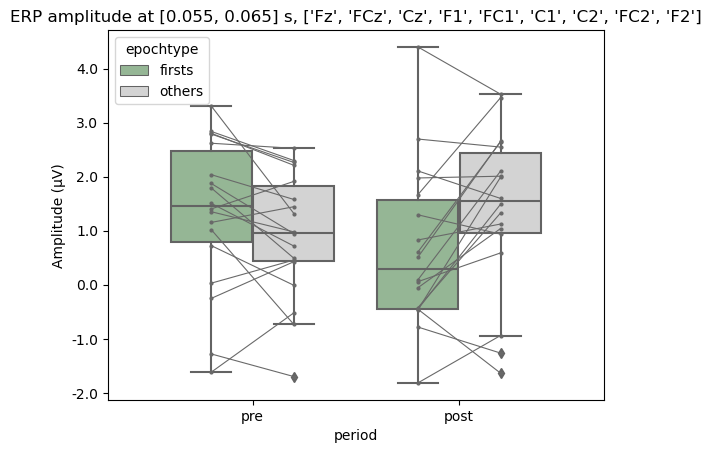

In [339]:
#plot anova comparison

palette= {
    'firsts': 'darkseagreen',  # Adjust alpha for transparency
    'others': 'lightgray'
}

ax = sns.boxplot(data = ev_df_combined, 
                 x = 'period', 
                 y = 'amp_attime', 
                 hue = 'epochtype', 
                 dodge = True, 
                 palette = palette)

for period in ev_df_combined['period'].unique():
    print(period)
    if period == 'pre':
        x_pos =  [-0.2, 0.2]
    elif period == 'post':
        x_pos = [0.8, 1.2]

    for subject in ev_df_combined['subject'].unique():

        ev_toplot = ev_df_combined.query(f'subject == "{subject}" and period == "{period}"')
        amp_firsts = ev_toplot.query(f'epochtype == "firsts"')['amp_attime'].values[0]
        amp_others = ev_toplot.query(f'epochtype == "others"')['amp_attime'].values[0]
        
    
        ax.plot(x_pos, [amp_firsts, amp_others], color = 'dimgrey', marker = 'o', markersize = 2, linewidth = 0.8)

plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV
ax.set_ylabel(f'Amplitude (µV)')
ax.set_title(f'ERP amplitude at {time_to_plot} s, {ch_to_test}')


## Comparing ERPs (old)

In [340]:
# # ARRANGE EPOCHS INFO INTO A DICTIONARY

# # Define dataset names and conditions
# datasets = {
#    # 'all': epochs_df_all,
#    # 'inv': epochs_df_inv,
#    # 'shinv': epochs_df_shinv,
#    # 'norm': epochs_df_norm,
#     'firsts': epochs_df_firsts,
#     'others': epochs_df_others
# }
# periods = ['pre', 'post']
# musician_status = {
#     'mus': 'musician == 1',
#     'nmus': 'musician == 0'
# }

# # Initialize dictionary
# epochs_dict = {}

# # Loop through datasets, periods, and musician status
# for dataset_name, dataset in datasets.items():
#     for period in periods:
#         for mus, condition in musician_status.items():
#             key = f'{dataset_name}_{period}_{mus}'
#             query_str = f"period == '{period}' and {condition}"
#             epochs_dict[key] = np.array(dataset.query(query_str)['epochs'].tolist())


In [341]:
# #testing specific channels 
# p_channels = ['Cz', 'FCz']
# p_ch_idx = ch_index(p_channels)
# ch_totest = p_channels


# compare_1 = np.array(epochs_df_firsts_sub.query("period == 'pre' ")['epochs'].tolist())
# compare_2 = np.array(epochs_df_others_sub.query("period == 'pre'")['epochs'].tolist())
# diff_evoked_sa = find_diff_sa(compare_1, compare_2)



# to_compare = [compare_1, compare_2]




In [342]:
#calculate p-value over time

#p_values = p_times(to_compare, channels = ch_totest) #independent t-test

#1-sample t-test on difference pre vs post

#p_within = p_times_1sample(diff_evoked_sa, channels = ch_totest, tmin = 0.05, tmax = 0.2)


In [343]:
# ######################
# # COMPARISON FIGURE
# ######################
# plot_labels = ['firsts', 'others']
# groupcolor = 'red'

# plt.figure()
# shade = 0.3 #change in shade between the two lines

# for i, data in enumerate(to_compare):
    

#     if ch_totest == 'all':
#         plt.title(f'Error ERP averaged over all channels')
#         mean_data = data.mean(axis=0)[0:64].mean(axis = 0)
#         sem_data = data.std(axis=0)[0:64].mean(axis = 0) / np.sqrt(data.shape[0])

#     elif ch_totest == p_channels:

#         plt.title(f'Error ERP averaged over {p_channels} channels')
#         mean_data = data.mean(axis=0)[p_ch_idx].mean(axis = 0)
#         sem_data = data.std(axis=0)[p_ch_idx].mean(axis = 0) / np.sqrt(data.shape[0])
    


#     #rescale data
#     mean_data = np.array([x * 1000000 for x in mean_data])
#     sem_data = np.array([x * 1000000 for x in sem_data])

#     plt.plot(erp_times, mean_data, label=plot_labels[i], color = groupcolor, alpha = shade)
#     plt.fill_between(erp_times, mean_data - sem_data, mean_data + sem_data, color = groupcolor, alpha=shade-0.2)
#     shade += 0.3



# #############################
# #plot significant points
# ###############################
# # #find timepoints where ERP is significantly different
# # #sig_idx_ind = [index for index, item in enumerate(p_values) if item < 0.05]
# # sig_idx_within = [index for index, item in enumerate(p_within) if item < 0.05]

# # #get y values
# # max_y = np.max(to_compare)  
# # #y_ind = [7.5]*len(sig_idx_ind)
# # y_within = [7]*len(sig_idx_within)
# # plt.scatter(erp_times[sig_idx_within], y_within, marker="*", color='grey', label = '1-sample Wilcoxon test')
# # #plt.scatter(erp_times[sig_idx_ind], y_ind, marker="*", color='rosybrown', label = 'independent t-test')


# #aesthetics
# plt.title('')
# plt.hlines(0, -0.5, 0.5, color = 'black')
# plt.vlines(0, -7, 7, color = 'black', linestyles= '--')
# plt.ylabel('$\mu$V')
# plt.xlabel('Time (s)')
# #plt.ylim(-6,6)
# plt.legend(loc = 'lower right')

# #plt.savefig(figs_dir+f'/ERP_{task}_{participants}.svg')

### Comparing channel topographies

In [344]:
# ep_info = load_ep_info() #mne info for positions

# #choosing times where there are significant differences
# timepoint  = 0.2 #in seconds
# time_idx = time_index([timepoint])[0] #converts the time in seconds to the closest available timepoint in ERP array, then gets the index of that timepoint

# #calculating p values over channels
# p_values_ch = p_chs(to_compare, time_idx, ttest = 'ind')

# #scaling p values by 1-p so that smaller p values are more red, and p>0.05 is replaced with 0
# p_values_ch_scaled = scale_p_channels(p_values_ch)


# fig, axes = plt.subplots()  # Use plt.subplots() to create a figure and axes
# axes.set_title(f't = {erp_times[time_idx]*1000} ms')
# im, cn = mne.viz.plot_topomap(p_values_ch_scaled, pos=ep_info, size=1, axes=axes, vlim = (0.95,1))  # Pass the axes object to the plot_topomap function



### Export epoch data

In [345]:
"""musicians_pre = np.mean(epochs_df_all.query("period == 'pre' and musician == 1")['epochs'], axis=0)
musicians_post = np.mean(epochs_df_all.query("period == 'post' and musician == 1")['epochs'], axis=0)
nonmusicians_pre = np.mean(epochs_df_all.query("period == 'pre' and musician == 0")['epochs'], axis=0)
nonmusicians_post = np.mean(epochs_df_all.query("period == 'post' and musician == 0")['epochs'], axis=0)

savemat('playing_epochs.mat',{
    'mus_pre': musicians_pre,
    'mus_post': musicians_post,
    'nmus_pre': nonmusicians_pre,
    'nmus_post': nonmusicians_post,
    'fs':128,
    'erp_times': erp_times

})"""

'musicians_pre = np.mean(epochs_df_all.query("period == \'pre\' and musician == 1")[\'epochs\'], axis=0)\nmusicians_post = np.mean(epochs_df_all.query("period == \'post\' and musician == 1")[\'epochs\'], axis=0)\nnonmusicians_pre = np.mean(epochs_df_all.query("period == \'pre\' and musician == 0")[\'epochs\'], axis=0)\nnonmusicians_post = np.mean(epochs_df_all.query("period == \'post\' and musician == 0")[\'epochs\'], axis=0)\n\nsavemat(\'playing_epochs.mat\',{\n    \'mus_pre\': musicians_pre,\n    \'mus_post\': musicians_post,\n    \'nmus_pre\': nonmusicians_pre,\n    \'nmus_post\': nonmusicians_post,\n    \'fs\':128,\n    \'erp_times\': erp_times\n\n})'